In [1]:
# module import
import os
import sys
from datetime import datetime
import pickle

import numpy as np
import PIL.Image
import torch
import torchvision
                
sys.path.append('../cnn_preferred')
from utils import normalise_img, clip_extreme_pixel, save_video, normalise_vid, get_cnn_features, img_deprocess, get_target_feature_shape
from activation_maximization import generate_preferred

In [228]:
# network load
#net = torchvision.models.alexnet(pretrained=True)
net = torchvision.models.densenet121(pretrained=True)
net = torchvision.models.inception_v3(pretrained=True)
net.eval()

/Users/admin/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/torchvision-0.2.1-py3.6.egg/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [229]:
# image mean and std for pre/de-process image for input network
img_mean=np.array([0.485, 0.456, 0.406],dtype=np.float),
img_std = np.array([0.229,0.224,0.225])

# if the model input is for 0-1 range, norm = 255, elif 0-255, norm = 1
norm = 255

In [237]:
#save_dir
save_dir = '../result'
save_folder = 'jupyter_demo_torch_complexCNN_conv'
save_folder = save_folder + '_' + datetime.now().strftime('%Y%m%dT%H%M%S')
save_path = os.path.join(save_dir,save_folder)
os.makedirs(save_path, exist_ok=True)

In [230]:
# initial image for the optimization
h, w = 299,299
#h,w = 224, 224
initial_input = np.random.randint(0, 256, (h,w,3))

In [231]:
net

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [241]:
net.Mixed_7a.branch7x7x3_3.conv

Parameter containing:
tensor([[[[-1.7625e-03],
          [-2.4767e-02],
          [-5.6810e-04],
          ...,
          [ 2.1643e-03],
          [-1.0925e-02],
          [-2.3736e-02]],

         [[-1.9332e-02],
          [-3.9892e-04],
          [-8.1151e-03],
          ...,
          [-4.3738e-03],
          [ 2.1863e-03],
          [ 5.7849e-03]],

         [[ 1.4833e-02],
          [-1.4461e-03],
          [ 7.9768e-03],
          ...,
          [ 1.1194e-03],
          [-7.2513e-03],
          [-2.0861e-02]],

         ...,

         [[ 1.0406e-02],
          [ 6.2353e-03],
          [ 1.3261e-02],
          ...,
          [-3.0067e-02],
          [-1.1480e-03],
          [-2.0758e-02]],

         [[-1.1532e-02],
          [-1.6888e-02],
          [ 2.5861e-02],
          ...,
          [ 1.7977e-02],
          [ 7.7242e-03],
          [ 3.1774e-03]],

         [[ 1.3447e-02],
          [ 3.5315e-03],
          [ 1.7023e-02],
          ...,
          [ 4.0129e-03],
          [-5

In [242]:
target_layer = "net.classifier[6]"
target_layer = "net.features.denseblock1.denselayer2.conv1"
#target_layer = "net.features.conv0"
#target_layer = "net.Conv2d_2a_3x3.conv"
target_layer = "net.fc"
target_layer = "net.Mixed_7a.branch7x7x3_3.conv"

In [243]:
#target layer setting
exec_str_list = [target_layer +".register_forward_hook(hook)"]
## obtain target feature shape
# transform input shape for torch avairable shape
initial_torch_input = torch.Tensor(initial_input.transpose(2,0, 1)[np.newaxis])
# obtain target layer activation 
feat_shape = get_target_feature_shape(net, initial_torch_input, exec_str_list)

In [244]:
feat_shape

(1, 192, 17, 17)

In [245]:
# options
opts = {
    'img_mean': img_mean, #img_mean to preprocessing input image
    'img_std': img_std,   #img_std to preprocessing input image
    'norm': norm,         #if the model input is for 0-1 range, norm = 255, elif 0-255, norm = 1
    
    'iter_n': 200, # the total number of iterations for gradient descend

    'disp_every': 1, # display the information on the terminal for every n iterations

    'save_intermediate': True, # save the intermediate or not
    'save_intermediate_every': 10, # save the intermediate for every n iterations
    'save_intermediate_path': save_path, # the path to save the intermediate

    'lr_start':1, # learning rate
    'lr_end': 1,   # we can change learning rate linearly setteing these two parameters

    'momentum_start': 0.001, # gradient with momentum
    'momentum_end': 0.001,   # we can change momentum linearly setteing these two parameters too

    'decay_start': 0.001, # pixel decay for each iteration
    'decay_end': 0.001,   # we can also change pixel decay linealy 

    'image_blur': True, # Use image smoothing or not
    'sigma_start': 2.5, # the size of the gaussian filter for image smoothing
    'sigma_end': 0.5,

    'image_jitter': True, # use image jittering during optimization
    'jitter_size': 32,
    
    'use_p_norm_reg': False, # use p_norm regularization
    'p': 2,

    'use_TV_norm_reg': False,
    'TVbeta1': 1, 
    'TVbeta2':1.2,

    'clip_small_norm': True,
    'clip_small_norm_every': 1,
    'n_pct_start': 5,
    'n_pct_end': 5,

    'clip_small_contribution': True,
    'clip_small_contribution_every': 1,
    'c_pct_start': 5,
    'c_pct_end':5,
    
    'input_size': (224,224,3),
    'initial_input': initial_input, # the initial image for the optimization (setting to None will use random noise as initial image)
    }



In [246]:
channel_list = [14,56]

In [247]:
for channel in channel_list:
    #
    print('')
    print('channel='+str(channel))
    print('')

    # target units
    feat_size = feat_shape
    #y_index = int(feat_size[2]/2) # the unit in the center of feature map
    #x_index = int(feat_size[3]/2) # the unit in the center of feature map
    feature_mask = np.zeros(feat_size)
    #feature_mask[0,channel,y_index,x_index] = 1
    
    feature_mask[0,channel] = 1
    #feature_mask[0,:] = 1
    # weights for the target units
    feature_weight = np.zeros(feat_size, dtype=np.float32)
    #feature_weight[0,:] = -1000
    feature_weight[0,channel] = 1
    
    #
    preferred_stim = generate_preferred(net, exec_str_list, feature_mask=feature_mask, **opts)
    # save the results
    save_name = 'preferred_img' + '_layer_' + str(target_layer) + '_channel_' + str(channel) + '.npy'
    np.save(os.path.join(save_path,save_name), preferred_stim)

    save_name = 'preferred_img' + '_layer_' + str(target_layer) + '_channel_' + str(channel) + '.jpg'
    #save_video(normalise_vid(clip_extreme_pixel(preferred_stim,pct=0.04)), save_name, save_path )
    PIL.Image.fromarray(normalise_img(clip_extreme_pixel(preferred_stim, pct=0.04))).save(
                    os.path.join(save_path, save_name))


channel=14

iter=1; mean(abs(feat))=0.230426;
iter=2; mean(abs(feat))=0.056244;
iter=3; mean(abs(feat))=0.0748654;
iter=4; mean(abs(feat))=0.194894;
iter=5; mean(abs(feat))=0.288147;
iter=6; mean(abs(feat))=0.0204704;
iter=7; mean(abs(feat))=0.0208692;
iter=8; mean(abs(feat))=0.0192401;
iter=9; mean(abs(feat))=0.192793;
iter=10; mean(abs(feat))=0.074365;
iter=11; mean(abs(feat))=0.269971;
iter=12; mean(abs(feat))=0.189908;
iter=13; mean(abs(feat))=0.0589864;
iter=14; mean(abs(feat))=0.0862016;
iter=15; mean(abs(feat))=0.202542;
iter=16; mean(abs(feat))=0.135572;
iter=17; mean(abs(feat))=0.0944167;
iter=18; mean(abs(feat))=0.148382;
iter=19; mean(abs(feat))=0.0757474;
iter=20; mean(abs(feat))=0.0674015;
iter=21; mean(abs(feat))=0.0612247;
iter=22; mean(abs(feat))=0.137429;
iter=23; mean(abs(feat))=0.119683;
iter=24; mean(abs(feat))=0.0726227;
iter=25; mean(abs(feat))=0.104309;
iter=26; mean(abs(feat))=0.132647;
iter=27; mean(abs(feat))=0.214814;
iter=28; mean(abs(feat))=0.158855;
iter=

iter=32; mean(abs(feat))=0.230684;
iter=33; mean(abs(feat))=0.823888;
iter=34; mean(abs(feat))=0.450295;
iter=35; mean(abs(feat))=0.483625;
iter=36; mean(abs(feat))=0.557599;
iter=37; mean(abs(feat))=0.0283726;
iter=38; mean(abs(feat))=0.496292;
iter=39; mean(abs(feat))=0.511902;
iter=40; mean(abs(feat))=0.48671;
iter=41; mean(abs(feat))=0.0553669;
iter=42; mean(abs(feat))=0.866332;
iter=43; mean(abs(feat))=0.479298;
iter=44; mean(abs(feat))=0.81162;
iter=45; mean(abs(feat))=0.870918;
iter=46; mean(abs(feat))=1.17696;
iter=47; mean(abs(feat))=0.181338;
iter=48; mean(abs(feat))=0.749981;
iter=49; mean(abs(feat))=0.52241;
iter=50; mean(abs(feat))=0.312661;
iter=51; mean(abs(feat))=0.37186;
iter=52; mean(abs(feat))=0.8106;
iter=53; mean(abs(feat))=0.132716;
iter=54; mean(abs(feat))=0.787017;
iter=55; mean(abs(feat))=0.63477;
iter=56; mean(abs(feat))=0.40767;
iter=57; mean(abs(feat))=0.807382;
iter=58; mean(abs(feat))=0.16544;
iter=59; mean(abs(feat))=0.869419;
iter=60; mean(abs(feat))=0.0

In [239]:
ee= get_cnn_features(net, torch.Tensor(preferred_stim.transpose(2,0,1)[np.newaxis]), exec_str_list)

In [80]:
import matplotlib.pyplot as plt

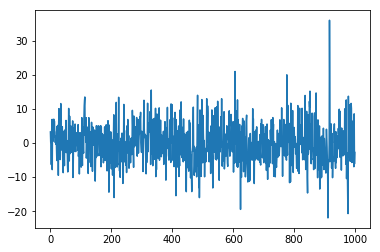

In [240]:
plt.plot(ee[0].detach().numpy()[0])

In [88]:
net.classifier.weight.detach().numpy().min()

-0.29465234